In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import datetime
import warnings
%matplotlib inline
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

### Residuals TS

In [192]:
#Load residuals and set index as datetime
residuals = pd.read_csv('Residuals_from_random_forest.csv', encoding='latin1', index_col='date_hour')
residuals.index = residuals.index.to_datetime()

In [194]:
converted = residuals.asfreq('H')

In [198]:
converted[converted['residuals'].isnull()]

,residuals
2014-03-30 02:00:00,NaN
2015-03-29 02:00:00,NaN
2016-03-27 02:00:00,NaN


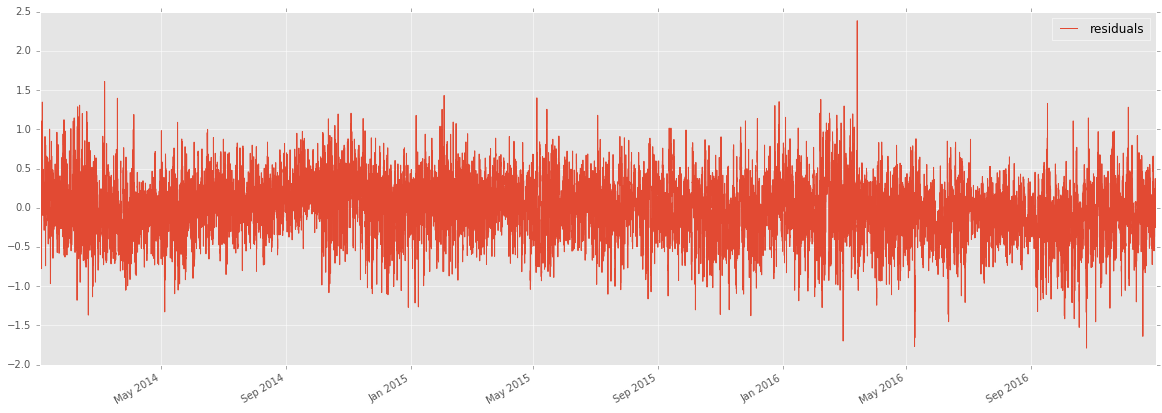

In [15]:
#Plot residual TS
residuals.plot(figsize=(20,7))

### Dick-Fuller test on stationarity

In [23]:
from statsmodels.tsa.stattools import adfuller

In [24]:
def perform_stationarity_test(timeseries):
    print('Results of the Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutpout = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags used',
                                             'Number of observation used'])
    for key, value in dftest[4].items():
        dfoutpout['Critical value (%s)'%key] = value
    print(dfoutpout)

In [25]:
perform_stationarity_test(residuals['residuals'])

Results of the Dickey-Fuller Test:
Test Statistic               -1.805473e+01
p-value                       2.632826e-30
#Lags used                    4.900000e+01
Number of observation used    2.622700e+04
Critical value (10%)         -2.566829e+00
Critical value (1%)          -3.430599e+00
Critical value (5%)          -2.861650e+00
dtype: float64


### ACF and PACF

In [26]:
from statsmodels.tsa.stattools import acf, pacf

In [34]:
def computer_acf_pacf(timeseries, acf_lags, pacf_lags):
    lag_acf = acf(timeseries, nlags=acf_lags)
    lag_acf_df = pd.DataFrame(lag_acf, columns=['ACF'])
    lag_acf_df.index.name = 'Hour'
    
    lag_pacf = pacf(timeseries.dropna(), nlags=pacf_lags)
    lag_pacf_df = pd.DataFrame(lag_pacf, columns=['PACF'])
    lag_pacf_df.index.name = 'Hour'
    
    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(20,15))
    lag_acf_df.iloc[:100].plot(kind='bar', ax=ax0)
    ax0.axhline(y=-1.96/np.sqrt(len(lag_acf)), linestyle='--', color='blue')
    ax0.axhline(y=+1.96/np.sqrt(len(lag_acf)), linestyle='--', color='blue')
    lag_pacf_df.iloc[:100].plot(kind='bar', ax=ax1);
    ax1.axhline(y=-1.96/np.sqrt(len(lag_pacf)), linestyle='--', color='blue')
    ax1.axhline(y=+1.96/np.sqrt(len(lag_pacf)), linestyle='--', color='blue')

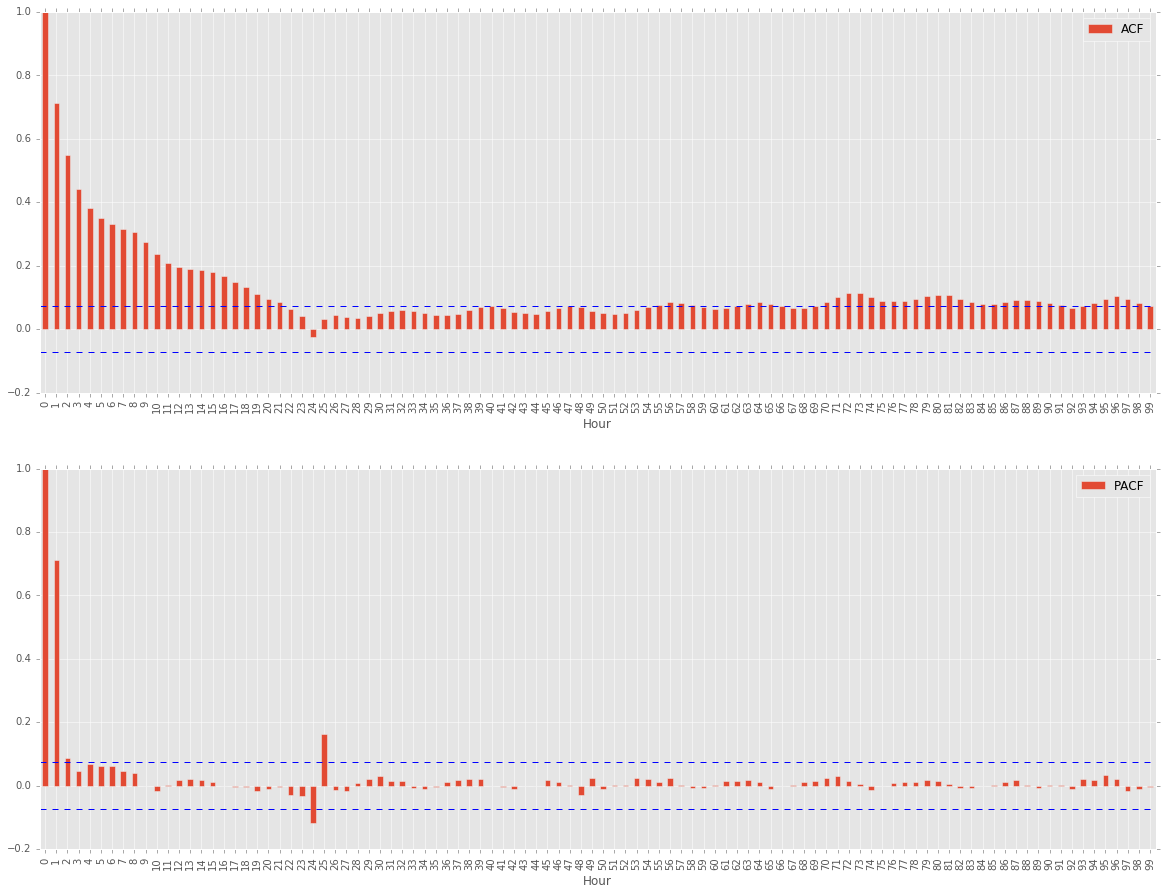

In [35]:
#ACF and PACF suggest an ARMA model with p = 2 or 3 and q = 0
computer_acf_pacf(residuals['residuals'], 720, 720)

### ARIMA model, p=2; q=0

In [76]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import TimeSeriesSplit

In [123]:
def compute_ARIMA_model(timeseries, p, d, q):
    model = ARIMA(timeseries, order=(p,d,q))
    results = model.fit(disp=-1, maxiter=500)
    return results

In [185]:
residuals.index

AttributeError: 'str' object has no attribute 'freqstr'

In [183]:
residuals.index

AttributeError: 'str' object has no attribute 'freqstr'

In [171]:
model = compute_ARIMA_model(residuals['residuals'], 3, 0, 2)

In [175]:
residuals.shape

(26277, 1)

In [178]:
model.predict(start='2016', end='2017')

ValueError: Must provide freq argument if no data is supplied

ValueError: Must provide freq argument if no data is supplied

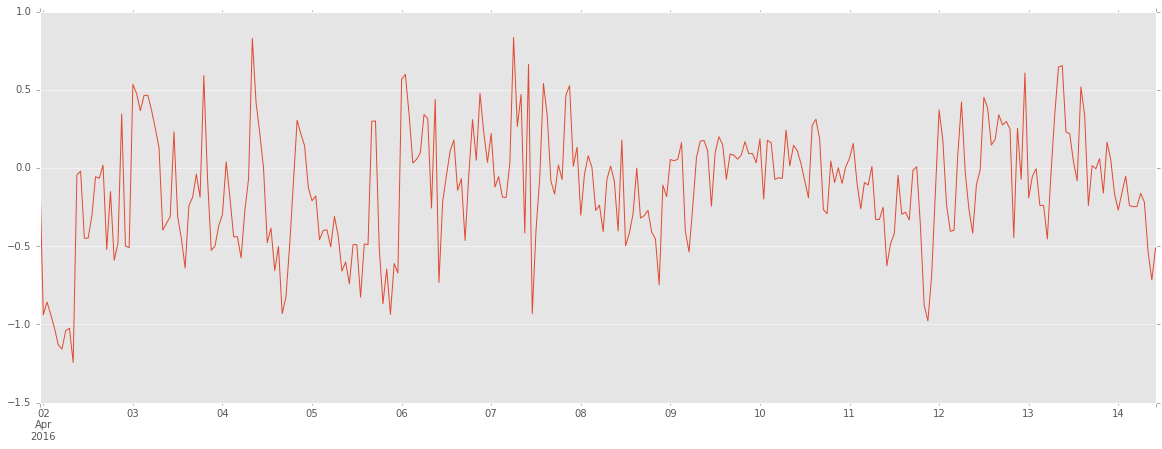

In [167]:
fig, ax = plt.subplots(1, 1, figsize=(20,7))
residuals.iloc[19700:20000]['residuals'].plot(ax=ax)
pd.DataFrame(data=model.predict(start='2016-02-01 00:00:00', end='2016-05-01 00:00:00', dynamic=False)).plot(ax=ax)

In [162]:
residuals.iloc[19707]

residuals   -1.040065
Name: 2016-04-02 06:00:00, dtype: float64

In [170]:
pd.DataFrame(data=model.predict(start='2014-04-02', 
                                end='2016-04-14', dynamic=False)).plot(figsize=(20,10))

ValueError: Must provide freq argument if no data is supplied

In [168]:
pd.DataFrame(data=model.predict(start='2014-01-03 00:00:00', end='2016-10-01 00:00:00', dynamic=False)).plot(figsize=(20,10))

ValueError: Must provide freq argument if no data is supplied

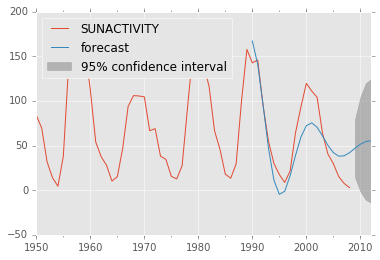

In [122]:
 import statsmodels.api as sm
>>> import matplotlib.pyplot as plt
>>> import pandas as pd
>>>
>>> dta = sm.datasets.sunspots.load_pandas().data[['SUNACTIVITY']]
>>> dta.index = pd.DatetimeIndex(start='1700', end='2009', freq='A')
>>> res = sm.tsa.ARMA(dta, (3, 0)).fit()
>>> fig, ax = plt.subplots()
>>> ax = dta.ix['1950':].plot(ax=ax)
>>> fig = res.plot_predict('1990', '2012', dynamic=True, ax=ax,
...                        plot_insample=False)
>>> plt.show()

In [127]:
res.predict(start='1990', end='2012')

1990-12-31    167.047416
1991-12-31    109.191565
1992-12-31    113.403582
1993-12-31     46.911611
1994-12-31     20.983506
1995-12-31     15.688764
1996-12-31     17.255696
1997-12-31     15.181180
1998-12-31     38.091306
1999-12-31     88.365454
2000-12-31    102.670097
2001-12-31    116.597712
2002-12-31     88.288075
2003-12-31     80.142219
2004-12-31     32.391216
2005-12-31     23.466025
2006-12-31     26.740874
2007-12-31     16.155666
2008-12-31     14.931867
2009-12-31     14.753338
2010-12-31     33.507804
2011-12-31     52.477593
2012-12-31     66.087896
Freq: A-DEC, dtype: float64

In [ ]:
#Cross-validation for ARIMA timeseries
tscv = TimeSeriesSplit(n_splits=3)

for train_index, test_index in tscv.split(residuals['residuals'].values):

In [81]:
tscv = TimeSeriesSplit(n_splits=3)

In [82]:
for train_index, test_index in tscv.split(residuals['residuals'].values):

TRAIN:  [   0    1    2 ..., 6567 6568 6569] TEST:  [ 6570  6571  6572 ..., 13136 13137 13138]
TRAIN:  [    0     1     2 ..., 13136 13137 13138] TEST:  [13139 13140 13141 ..., 19705 19706 19707]
TRAIN:  [    0     1     2 ..., 19705 19706 19707] TEST:  [19708 19709 19710 ..., 26274 26275 26276]


In [59]:
model_fitted = compute_ARIMA_model(residuals['residuals'], 3, 0, 0)

In [75]:
model_fitted